In [269]:
%matplotlib inline

import string
import numpy as np
import pandas as pd4

import matplotlib.pyplot as plt

from tqdm import tqdm

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from bert.tokenization.bert_tokenization import FullTokenizer

# For Glove examples 
from scipy import spatial
from sklearn.manifold import TSNE

import nltk


import warnings
warnings.filterwarnings('ignore')

In [270]:
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidkolb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [271]:
train = pd.read_csv('../../Data/NLPNovice/train.csv')
test = pd.read_csv('../../Data/NLPNovice/test.csv')

In [272]:
train.describe, test.describe

(<bound method NDFrame.describe of          id keyword location  \
 0         1     NaN      NaN   
 1         4     NaN      NaN   
 2         5     NaN      NaN   
 3         6     NaN      NaN   
 4         7     NaN      NaN   
 ...     ...     ...      ...   
 7608  10869     NaN      NaN   
 7609  10870     NaN      NaN   
 7610  10871     NaN      NaN   
 7611  10872     NaN      NaN   
 7612  10873     NaN      NaN   
 
                                                    text  target  
 0     Our Deeds are the Reason of this #earthquake M...       1  
 1                Forest fire near La Ronge Sask. Canada       1  
 2     All residents asked to 'shelter in place' are ...       1  
 3     13,000 people receive #wildfires evacuation or...       1  
 4     Just got sent this photo from Ruby #Alaska as ...       1  
 ...                                                 ...     ...  
 7608  Two giant cranes holding a bridge collapse int...       1  
 7609  @aria_ahrary @TheTawniest

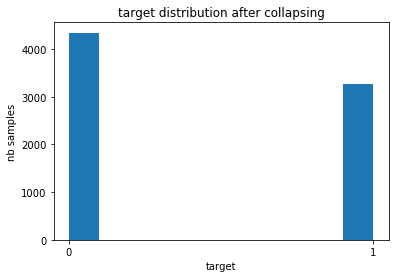

In [273]:
target = train['target']
plt.hist(target)
plt.xlabel('target')
plt.ylabel('nb samples')
plt.title('target distribution after collapsing')
plt.xticks(np.arange(len(np.unique(target))));

In [274]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [275]:
train.head(20)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [276]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int64
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


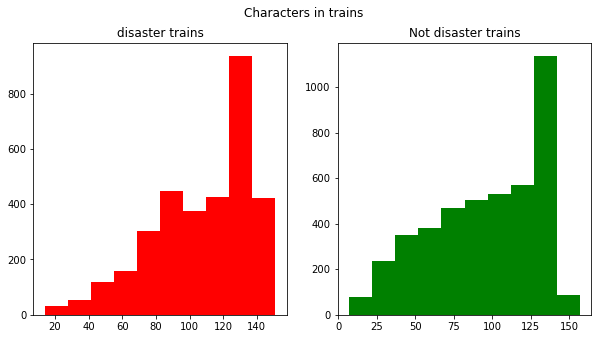

In [277]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
train_len=train[train['target']==1]['text'].str.len()
ax1.hist(train_len,color='red')
ax1.set_title('disaster trains')
train_len=train[train['target']==0]['text'].str.len()
ax2.hist(train_len,color='green')
ax2.set_title('Not disaster trains')
fig.suptitle('Characters in trains')
plt.show()

In [278]:
#Check missing train data ratios 
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data.head()

,Missing Ratio
location,33.272035
keyword,0.801261


In [279]:
#Check missing test data ratios 
test_na = (test.isnull().sum() / len(test)) * 100
test_na = test_na.drop(test_na[test_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :test_na})
missing_data.head()

,Missing Ratio
location,33.864542
keyword,0.796813


In [280]:
#check for skewwness in data 
skewness = pd.DataFrame(train.skew(axis = 0, skipna = True).sort_values(ascending=False), columns=['Skew'])
skewness

,Skew
target,0.284243
id,0.007607


In [281]:
#Add meta data features
# word_count
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train['stop_word_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test['stop_word_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train['url_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test['url_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train['mean_word_length'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
test['char_count'] = test['text'].apply(lambda x: len(str(x)))

# punctuation_count
train['punctuation_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punctuation_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train['hashtag_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test['hashtag_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train['mention_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test['mention_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [282]:
# fig =plt.figure(figsize=(15,15),dpi=100)
# sns.set_context('notebook',font_scale=1.3)
# sns.set_style('whitegrid')
# g=sns.pairplot(train[['word_count',
#                 'unique_word_count',
#                 'stop_word_count',
#                 'char_count',
#                 'target']],hue='target')

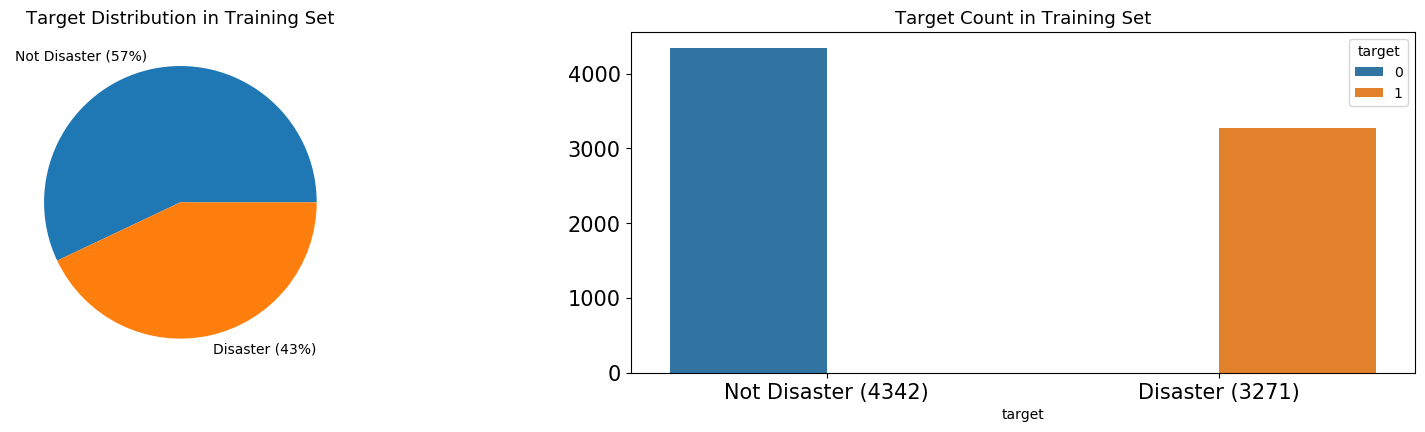

In [283]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=train['target'], hue=train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

In [284]:
# N-gram analysis
def get_top_train_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

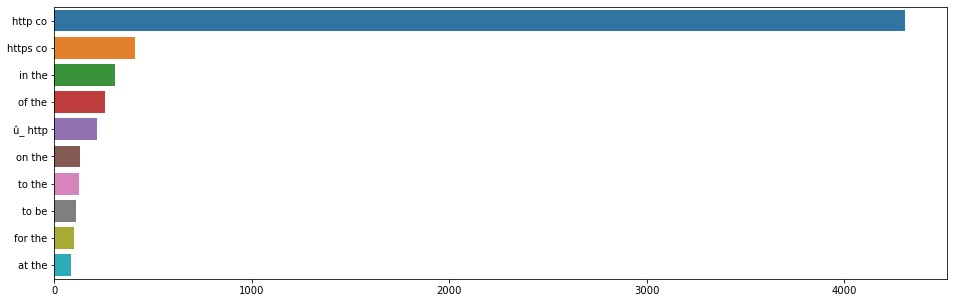

In [285]:
plt.figure(figsize=(16,5))
top_train_bigrams=get_top_train_bigrams(train['text'])[:10]
x,y=map(list,zip(*top_train_bigrams))
sns.barplot(x=y,y=x)

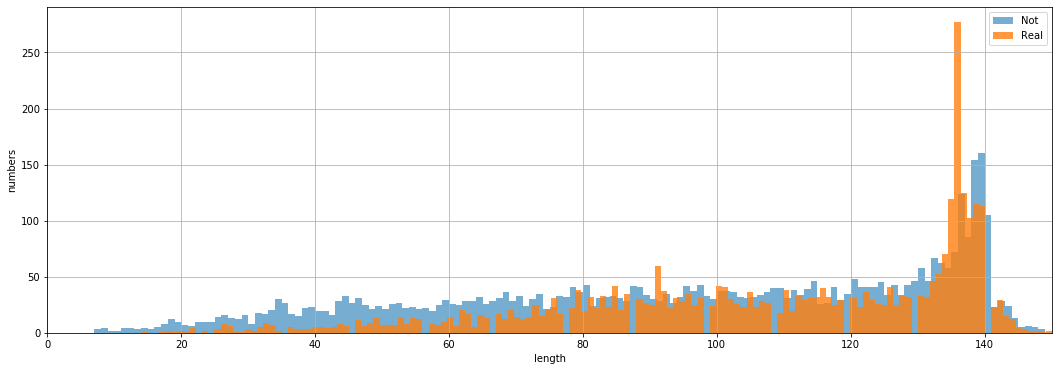

In [286]:
# Characters per tweet
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(train[train['target'] == 0]['char_count'], alpha = 0.6, bins=bins, label='Not')
plt.hist(train[train['target'] == 1]['char_count'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

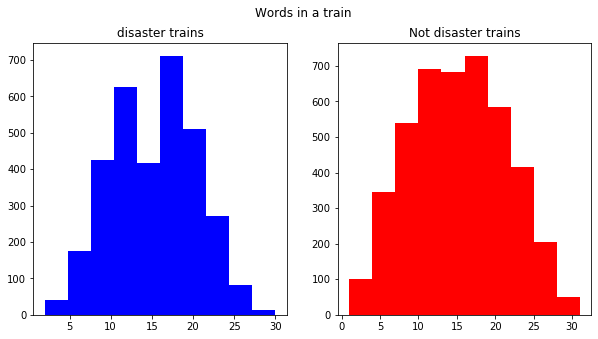

In [287]:
# Number of words in train
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
train_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(train_len,color='blue')
ax1.set_title('disaster trains')
train_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(train_len,color='red')
ax2.set_title('Not disaster trains')
fig.suptitle('Words in a train')
plt.show()

Text(0.5, 0.98, 'Average word length in each train')

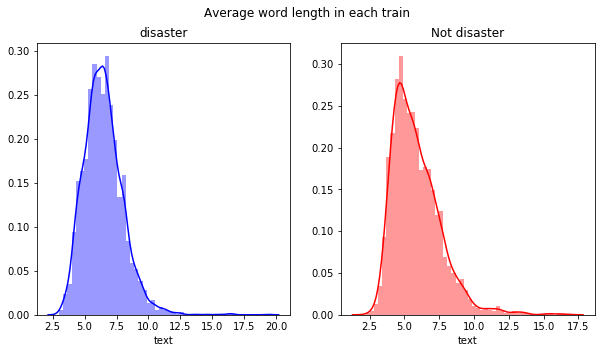

In [288]:
#Average word length in a train
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each train')

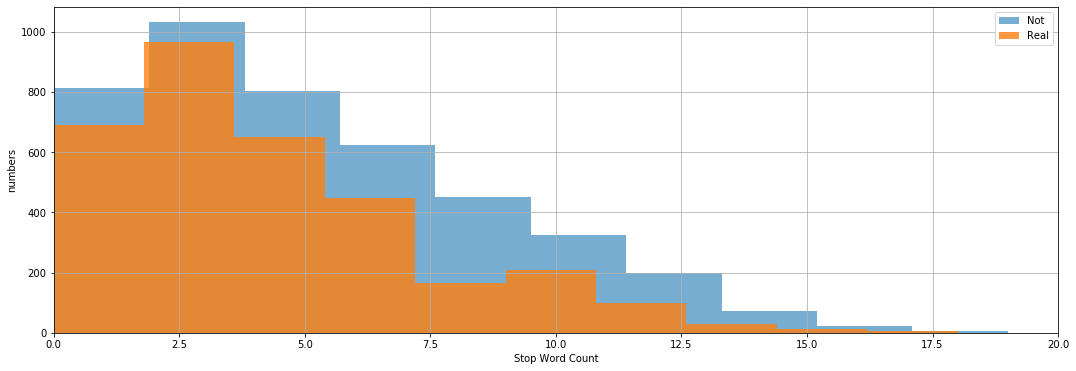

In [289]:
# stop_word_count
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 10
plt.hist(train[train['target'] == 0]['stop_word_count'], alpha = 0.6, bins=bins, label='Not')
plt.hist(train[train['target'] == 1]['stop_word_count'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('Stop Word Count')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,20)
plt.grid()
plt.show()

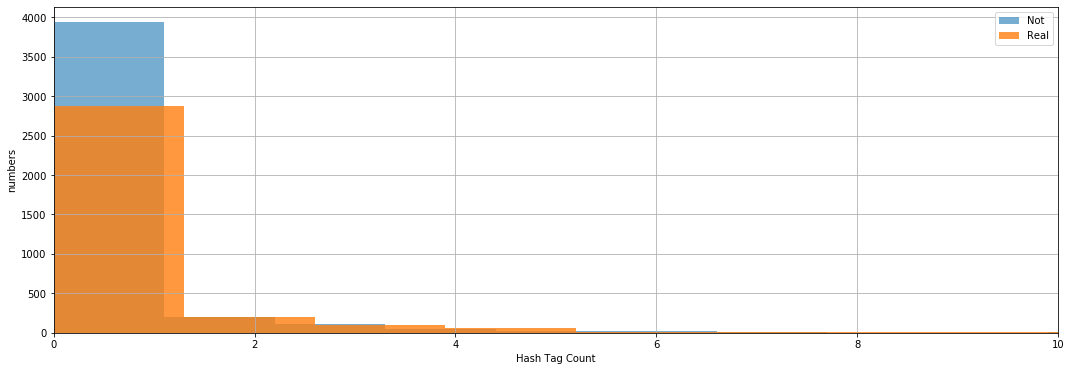

In [290]:
# hashtag_count
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 10
plt.hist(train[train['target'] == 0]['hashtag_count'], alpha = 0.6, bins=bins, label='Not')
plt.hist(train[train['target'] == 1]['hashtag_count'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('Hash Tag Count')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,10)
plt.grid()
plt.show()

In [291]:
#Create a list of words
def create_corpus(target):
    corpus=[]
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

#Create list of stop words
def stop_words(data):
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
    return dic

#Create list of puntcuation
def punt_words(data):
    dic=defaultdict(int)
    special = string.punctuation
    for i in (corpus):
        if i in special:
            dic[i]+=1
    return dic

<BarContainer object of 10 artists>

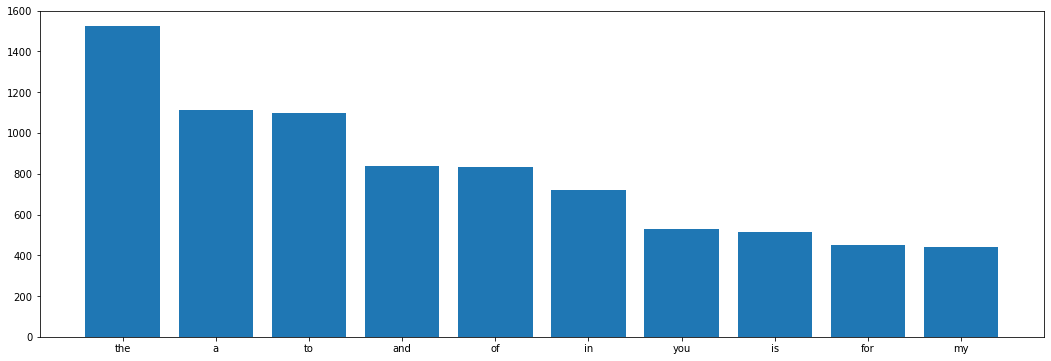

In [292]:
# Common stop words in class 0
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

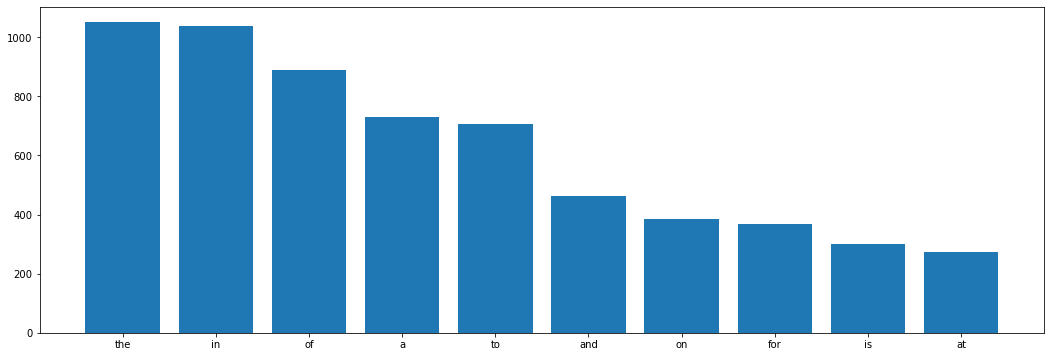

In [293]:
# Common stop words in class 1
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

# Cleaing the Data

In [294]:
def remove_whitespace(data):
    return data.strip()

In [295]:
def remove_URL(data):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',data)

In [296]:
def remove_html(data):
    html=re.compile(r'<.*?>')
    return html.sub(r'',data)

In [297]:
def remove_emoji(data):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', data)

In [298]:
def remove_accented_chars(data):
    return unicodedata.normalize('NFKD', data).encode('ascii', 'ignore').decode('utf-8', 'ignore')

In [299]:
def remove_punctuation(data):
    table=str.maketrans('','',string.punctuation)
    return data.translate(table)

In [300]:
def single_char(data):
    new_data=''
    for w in data:
        print(w)
        if len(w) > 1:
            print(w)
            new_data = new_data +  " " + w
    
    return new_data

In [301]:
def remove_special_characters(data, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    data = re.sub(pattern, '', data)
    return data

In [302]:
def convert_lower_case(data):
    return data.lower()

In [303]:
def tokenise(data):
    data = word_tokenize(data)
    return data

In [304]:
def remove_stop_words(data):
    filtered_sentence = [w for w in data if not w in stop_words] 
    return filtered_sentence

In [305]:
def stemming(data):
    data.apply(lambda x: [stemmer.stem(e) for e in x])
    return data

In [306]:
def lemmatise(data):
    lemmatizer = WordNetLemmatizer()
    data.apply(lambda x: [lemmatizer.lemmatize(e) for e in x])
    return data 

In [307]:
stop_words = set(stopwords.words('english')) 
stemmer = SnowballStemmer("english")

In [308]:
def nlp_clean(data):
    data = remove_URL(data)
    data = remove_html(data)
    data = remove_emoji(data)
    data = remove_whitespace(data)    
    data = remove_accented_chars(data) 
    data = remove_special_characters(data)
    data = remove_punctuation(data)
    data = convert_lower_case(data)
    return data
    
def nlp_tokenise(data):
    data = tokenise(data)
    data = remove_stop_words(data)
    return data
     
def nlp_normalise(data):
    data = stemming(data)
    data = lemmatise(data)
    return data

In [309]:
# Run preprossing steps to clean data
train['text']=train['text'].apply(lambda x : nlp_clean(x))
test['text']=test['text'].apply(lambda x : nlp_clean(x))

In [310]:
# Run steps to remove stop words
train['text']=train['text'].apply(lambda x : nlp_tokenise(x))
test['text']=test['text'].apply(lambda x : nlp_tokenise(x))

In [313]:
train['text'].head(30)

0     [deeds, reason, earthquake, may, allah, forgiv...
1         [forest, fire, near, la, ronge, sask, canada]
2     [residents, asked, shelter, place, notified, o...
3     [13000, people, receive, wildfires, evacuation...
4     [got, sent, photo, ruby, alaska, smoke, wildfi...
5     [rockyfire, update, california, hwy, 20, close...
6     [flood, disaster, heavy, rain, causes, flash, ...
7                     [im, top, hill, see, fire, woods]
8     [theres, emergency, evacuation, happening, bui...
9                   [im, afraid, tornado, coming, area]
10               [three, people, died, heat, wave, far]
11    [haha, south, tampa, getting, flooded, hah, wa...
12    [raining, flooding, florida, tampabay, tampa, ...
13                [flood, bago, myanmar, arrived, bago]
14    [damage, school, bus, 80, multi, car, crash, b...
15                                         [whats, man]
16                                       [love, fruits]
17                                     [summer, 

In [312]:
test['text'].head(30)

0                      [happened, terrible, car, crash]
1     [heard, earthquake, different, cities, stay, s...
2     [forest, fire, spot, pond, geese, fleeing, acr...
3            [apocalypse, lighting, spokane, wildfires]
4         [typhoon, soudelor, kills, 28, china, taiwan]
5                              [shakingits, earthquake]
6     [theyd, probably, still, show, life, arsenal, ...
7                                                 [hey]
8                                           [nice, hat]
9                                                [fuck]
10                                   [dont, like, cold]
11                                   [nooooooooo, dont]
12                                         [dont, tell]
13                                                   []
14                                            [awesome]
15    [birmingham, wholesale, market, ablaze, bbc, n...
16         [sunkxssedharry, wear, shorts, race, ablaze]
17    [previouslyondoyintv, toke, makinwauas, ma

In [314]:
#Join Data
def combine_text(list_of_text):
    combined_text = ''
    for word in list_of_text:
        combined_text = combined_text + ' ' + word
    return combined_text

In [315]:
train['text'] = train['text'].apply(lambda x : combine_text(x))
test['text'] = test['text'].apply(lambda x : combine_text(x))

In [318]:
train['text'].head(30)

0          deeds reason earthquake may allah forgive us
1                 forest fire near la ronge sask canada
2      residents asked shelter place notified office...
3      13000 people receive wildfires evacuation ord...
4      got sent photo ruby alaska smoke wildfires po...
5      rockyfire update california hwy 20 closed dir...
6      flood disaster heavy rain causes flash floodi...
7                            im top hill see fire woods
8      theres emergency evacuation happening buildin...
9                         im afraid tornado coming area
10                      three people died heat wave far
11     haha south tampa getting flooded hah wait sec...
12     raining flooding florida tampabay tampa 18 19...
13                      flood bago myanmar arrived bago
14        damage school bus 80 multi car crash breaking
15                                            whats man
16                                          love fruits
17                                        summer

In [319]:
test['text'].head(30)

0                           happened terrible car crash
1      heard earthquake different cities stay safe e...
2      forest fire spot pond geese fleeing across st...
3                 apocalypse lighting spokane wildfires
4                typhoon soudelor kills 28 china taiwan
5                                 shakingits earthquake
6      theyd probably still show life arsenal yester...
7                                                   hey
8                                              nice hat
9                                                  fuck
10                                       dont like cold
11                                      nooooooooo dont
12                                            dont tell
13                                                     
14                                              awesome
15     birmingham wholesale market ablaze bbc news f...
16               sunkxssedharry wear shorts race ablaze
17     previouslyondoyintv toke makinwauas marri

In [ ]:
train.drop(['word_count',
       'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
       'char_count', 'punctuation_count', 'hashtag_count', 'mention_count'], axis=1, inplace=True)
test.drop(['word_count', 'unique_word_count',
       'stop_word_count', 'url_count', 'mean_word_length', 'char_count',
       'punctuation_count', 'hashtag_count', 'mention_count'], axis=1, inplace=True)

In [320]:
train.to_csv('../../Data/NLPNovice/DSKtrain.csv', index=False)
test.to_csv('../../Data/NLPNovice/DSKtest.csv', index=False)

In [321]:
train.dtypes

id                     int64
keyword               object
location              object
text                  object
target                 int64
word_count             int64
unique_word_count      int64
stop_word_count        int64
url_count              int64
mean_word_length     float64
char_count             int64
punctuation_count      int64
hashtag_count          int64
mention_count          int64
dtype: object

# Load pre cleaned text files

In [322]:
# Load pre cleaned text files
train = pd.read_csv('../../Data/NLPNovice/DSKtrain.csv')
test = pd.read_csv('../../Data/NLPNovice/DSKtest.csv')

# Convert text column from object to string
train['text'] = train['text'].apply(lambda x : str(x))
test['text'] = test['text'].apply(lambda x : str(x))

# Prepare Tensor Flow Data

In [324]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [325]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [326]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)
maxlength=130

In [327]:
train_input = bert_encode(train.text.values, tokenizer, max_len=maxlength)

In [328]:
test_input = bert_encode(test.text.values, tokenizer, max_len=maxlength)
train_labels = train.target.values

# Define Tensor Flow Model

In [260]:
input_word_ids = Input(shape=(maxlength,), dtype=tf.int32, name="input_word_ids")
input_mask = Input(shape=(maxlength,), dtype=tf.int32, name="input_mask")
segment_ids = Input(shape=(maxlength,), dtype=tf.int32, name="segment_ids")

_, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids]) 

clf_output = sequence_output[:, 0, :]

out = Dense(1, activation='sigmoid')(clf_output)

model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 130)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 130)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 130)]        0                                            
__________________________________________________________________________________________________
keras_layer_4 (KerasLayer)      [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [261]:
history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    batch_size=16
)

Train on 6090 samples, validate on 1523 samples
Epoch 1/3
 608/6090 [=>............................] - ETA: 13:26:58 - loss: 0.6980 - accuracy: 0.5760

KeyboardInterrupt: 

In [ ]:
results = model.evaluate(modeltest, train['target'])
print(results)

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
predict=model.predict(modeltest)
predict=np.round(predict).astype(int).reshape(3263)
sub=pd.DataFrame({'id':test['id'].values.tolist(),'target':predict})

In [ ]:
test_pred = model.predict(test_input)

# Final Submission

In [172]:
pred = clf_tfidf.predict(test_tfidf)

In [174]:
pred.shape

(3263,)

In [175]:
train_pred_GloVe_int.shape

(7613, 1)

In [176]:
output=pd.DataFrame({'id':test.id, 'target':pred})
output.to_csv('../../Data/NLPNovice/DSKsubmission.csv', index=False)

In [213]:
output

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


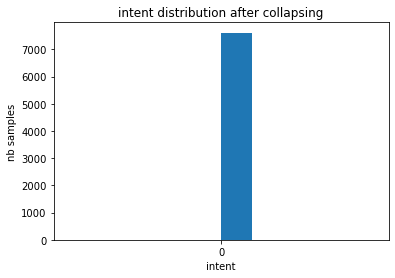

0       0
1       0
2       0
3       0
4       0
       ..
7608    0
7609    0
7610    0
7611    0
7612    0
Name: target, Length: 7613, dtype: int64